# CompBayes: Report03

## Uma Desai

MIT License: https://opensource.org/licenses/MIT

In [85]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import scipy.stats as stats

from thinkbayes2 import Pmf, Cdf, Suite, Joint, Beta
import thinkplot

## #1. Improving Reading Ability
#### This problem was taken from Allen Downey's Chapter 9 CompBayes workbook.

From DASL(http://lib.stat.cmu.edu/DASL/Stories/ImprovingReadingAbility.html)

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

> Summary statistics on the two groups of children show that the average score of the treatment class was almost ten points higher than the average of the control class. A two-sample t-test is appropriate for testing whether this difference is statistically significant. The t-statistic is 2.31, which is significant at the .05 level.



I'll use Pandas to load the data into a DataFrame.

In [33]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


And use `groupby` to compute the means for the two groups.

In [34]:
grouped = df.groupby('Treatment')
for name, group in grouped:
    print(name, group.Response.mean())

Control 41.5217391304
Treated 51.4761904762


The `Normal` class provides a `Likelihood` function that computes the likelihood of a sample from a normal distribution.

In [35]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

The prior distributions for `mu` and `sigma` are uniform.

In [36]:
mus = np.linspace(20, 80, 101)
sigmas = np.linspace(5, 30, 101)

I use `itertools.product` to enumerate all pairs of `mu` and `sigma`.

In [37]:
from itertools import product

control = Normal(product(mus, sigmas))
data = df[df.Treatment=='Control'].Response
control.Update(data)

1.791883192150766e-44

After the update, we can plot the probability of each `mu`-`sigma` pair as a contour plot.

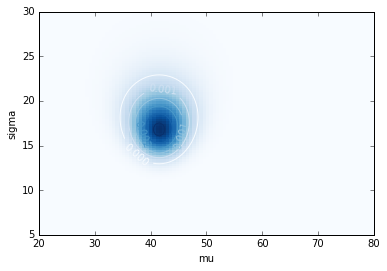

In [38]:
thinkplot.Contour(control, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

And then we can extract the marginal distribution of `mu`

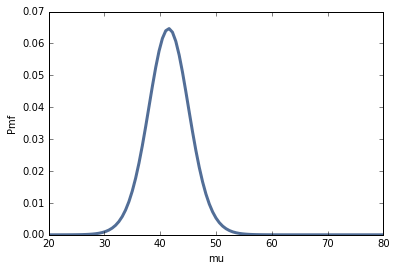

In [39]:
pmf_mu0 = control.Marginal(0)
thinkplot.Pdf(pmf_mu0)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

And the marginal distribution of `sigma`

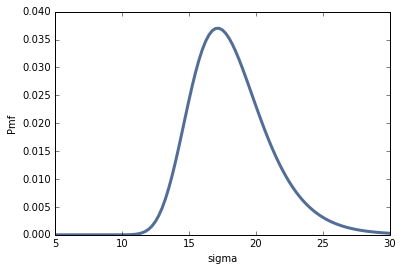

In [40]:
pmf_sigma0 = control.Marginal(1)
thinkplot.Pdf(pmf_sigma0)
thinkplot.Config(xlabel='sigma', ylabel='Pmf')

**Exercise:** Run this analysis again for the treated group.

In [41]:
treated = Normal(product(mus, sigmas))
data = df[df.Treatment=='Treated'].Response
treated.Update(data)

4.5285690956159087e-37

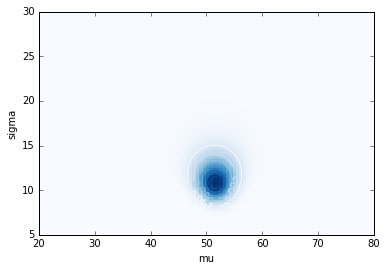

In [42]:
thinkplot.Contour(treated, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

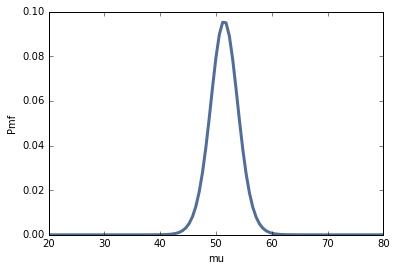

In [43]:
pmf_mu1 = treated.Marginal(0)
thinkplot.Pdf(pmf_mu1)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

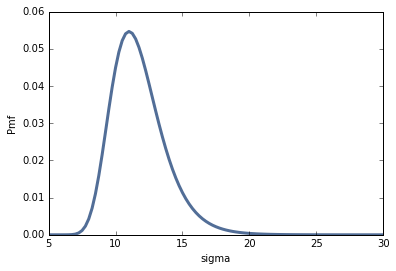

In [44]:
pmf_sigma1 = treated.Marginal(1)
thinkplot.Pdf(pmf_sigma1)
thinkplot.Config(xlabel='sigma', ylabel='Pmf')

**Exercise:** What is the distribution of the difference between the groups?

9.9544130889408731

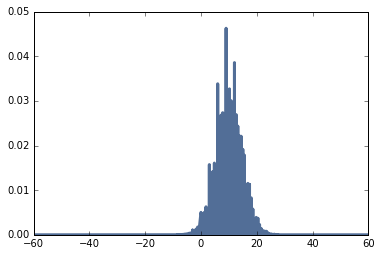

In [45]:
mu_difference = pmf_mu1 - pmf_mu0
thinkplot.Pdf(mu_difference)
mu_difference.Mean()

** Exercise:** What is the probability that the average "reading power" for the treatment group is higher?

0.98047902518732588

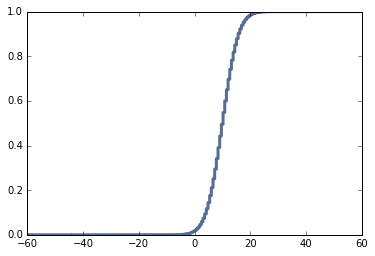

In [46]:
thinkplot.Cdf(mu_difference.MakeCdf())
# probability that the difference in mean rp is greater than 0
1 - mu_difference.MakeCdf()[0]

**Exercise:** What is the probability that the variance of the treatment group is higher?

-6.4171713281721887

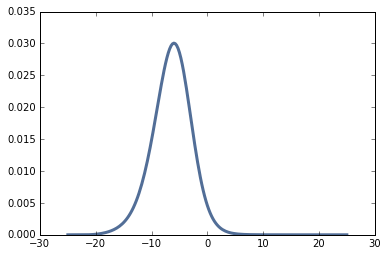

In [47]:
sigma_difference = pmf_sigma1 - pmf_sigma0
thinkplot.Pdf(sigma_difference)
sigma_difference.Mean()

0.026887481110575595

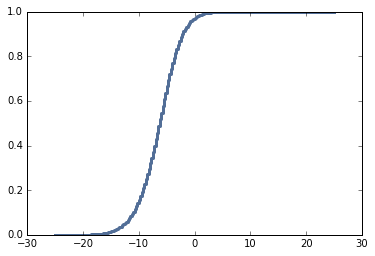

In [48]:
thinkplot.Cdf(sigma_difference.MakeCdf())
# probability that the difference in variance is greater than 0
1 - sigma_difference.MakeCdf()[0]

## #2. Coffee Cups Problem - Original Type 2

Recently at Olin, signs have been placed around the dining hall asking students to not use the paper cups as containers for food. Rumor has it that Rebecca's Cafe staff keep track of the number of paper coffee cups being used everyday to estimate how much coffee is being consumed each day and how much coffee they should make. I was both disappointed and shocked to hear this. Disappointed because I love using the paper cups as containers for my breakfasts-to-go, and shocked because this seems like a very inaccurate way to measure how much coffee is actually being consumed. Assuming that there is a certain probability of uncertainty U that a paper cup of coffee is being used for something other than actually drinking coffee or that a mug is being used for drinking coffee and isn't accounted for, can we find out on average how many cups of coffee a student actually drinks per day? Assume U = 0.75 and that on one given morning you count 52 missing paper coffe cups and 100 swipes into the dining hall.

In [86]:
class CoffeeEstimations(Suite):
    
    def __init__(self, prior, U):
        """
        prior = range of values
        z = probability that a cup of coffee is being used for something other than drinking coffee
        """
        Suite.__init__(self, prior)
        self.U = U
    
    def Likelihood(self, data, hypo):
        """
        data = (missing cups of coffee, number of dining hall entrance swipes)
        hypo = probability of a student drinking coffee, 0-100
        """
        U = self.U
        x = hypo / 100
        cups, swipes = data

        like = (x*U + (1-x)*(1-U))**cups * (x*(1-U) + (1-x)*U)**(swipes - cups)
        return like

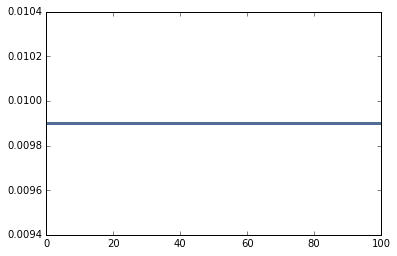

In [87]:
# Assume a normal distribution
suite = CoffeeEstimations(range(0, 101), 0.75)
thinkplot.Pdf(suite)

53.92155876021147

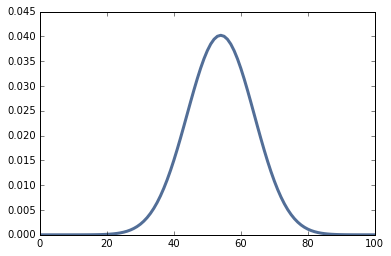

In [88]:
dataset = 52, 100
suite.Update(dataset)
thinkplot.Pdf(suite)
suite.Mean()

In [89]:
suite.CredibleInterval(90)

(38, 70)

These results indicate that the staff at Rebecca's cafe can expect each Olin student to drink about 0.54 cups of coffee each day. However, since there is uncertainty surrounding what the paper coffee cups are actually being used for, the spread of the probability of a student drinking coffee is fairly large, especially considering that the credible interval spans a huge range of possible values. This problem is a great example of how modeling decisions can so drastically change the results of a problem. If the uncertainty increases, the posterior distribution's peak becomes less pronounced, and if U reaches 0.5, the reliability of the coffee cup estimation is so unreliable that the data does not provide us with any useful information and the posterior distribution is uniform.

Outcomes with different values of U:

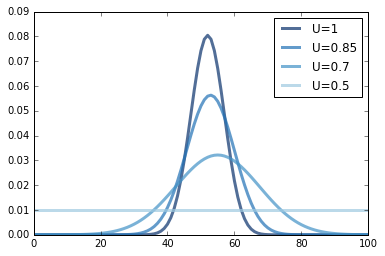

In [80]:
def changeU(U):
    suite = CoffeeEstimations(range(0, 101), U=U)
    dataset = 52, 100
    suite.Update(dataset)
    thinkplot.Pdf(suite, label='U=%g' % U)
    
changeU(1)
changeU(0.85)
changeU(0.7)
changeU(0.5)
thinkplot.config(legend=True)

## #3. Bug Problem
#### This problem was taken from Allen Downey's Chapter 9 CompBayes workbook.

**Exercise:** From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

I first look at this problem in the forward direction, where I assume values for p1, p2, and n. 

In [ ]:
# probabilities of finding a bug for each tester
p1 = 0.2
p2 = 0.1
# total number of bugs
n = 100
# if random number between 0 and 1 is less than the probability of tester finding the bug,
# add a true to a vector of booleans
k1_vector = np.random.random(n) < p1
k2_vector = np.random.random(n) < p2
# sums the number of True values in each vector
k1 = np.sum(k1_vector)
k2 = np.sum(k2_vector)
# takes the sum of the number of overlapping values between the two vectors
c = np.sum(k1_vector & k2_vector)
print(c)

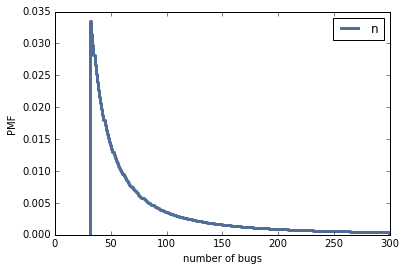

In [127]:
class Bugs(Suite, Joint):
    """Produces the Bayesian estimate about the number of errors based on the data."""
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        k1 = bugs found by tester 1
        k2 = bugs found by tester 2
        c = overlapping bugs found
        n = actual number of bugs
        p1 = probability of tester 1 finding bug
        p2 = probability of tester 2 finding bug
        """
        k1, k2, c = data
        n, p1, p2 = hypo
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        likes = like1 * like2
        return likes

# at least 32 different bugs have been found
bugs = range(32,300)
p1errors = np.linspace(0, 1, 101)
p2errors = np.linspace(0, 1, 101)

params = [(n, p1, p2)
         for n in bugs
         for p1 in p1errors
         for p2 in p2errors]

data = (20, 15, 3)
suite = Bugs(params)
suite.Update(data)
n_marginal = suite.Marginal(0)
thinkplot.Pmf(n_marginal, label='n')
thinkplot.Config(xlabel='number of bugs',
                   ylabel='PMF')

In [128]:
n_marginal.Mean()

80.058608905584876

The mean number of bugs appears to be around 80. This is slightly different from the 100 bug estimate made by the Lincoln index, probably because of the way this Bayes estimation was modeled.

## #4. GPS Problem
####  This problem was taken from Allen Downey's Chapter 9 CompBayes workbook.
According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

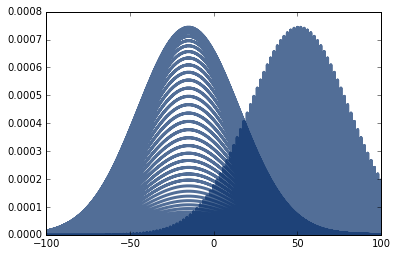

In [119]:
# this script uses code from gps.py
class Gps(Suite, Joint):
    """Represents hypotheses about your location in the field."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: (x, y)
        data: (coordx, coordy)
        """
        mean = 0
        std = 30
        x, y = hypo
        coordx, coordy = data
        like = norm.pdf(coordx, x, std)*norm.pdf(coordy, y, std)
        return like

coords = np.linspace(-100, 100, 101)
joint = Gps(product(coords, coords))
joint.Update((51, -15))
thinkplot.Pdf(joint)

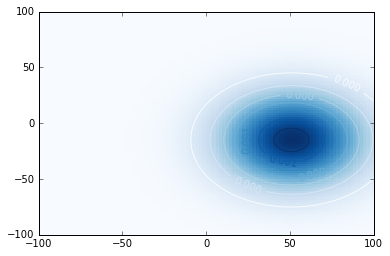

In [120]:
thinkplot.Contour(joint, pcolor = True)

Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)
    
At this point, how certain are you about your location?

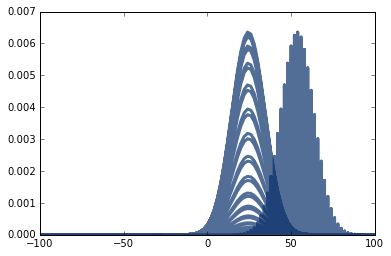

In [121]:
pairs = [(11.903060613102866, 19.79168669735705),
         (77.10743601503178, 39.87062906535289),
         (80.16596823095534, -12.797927542984425),
         (67.38157493119053, 83.52841028148538),
         (89.43965206875271, 20.52141889230797),
         (58.794021026248245, 30.23054016065644),
         (2.5844401241265302, 51.012041625783766),
         (45.58108994142448, 3.5718287379754585)]
joint.UpdateSet(pairs)
thinkplot.Pdf(joint)

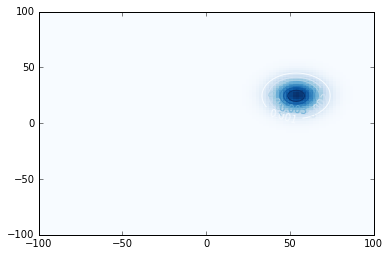

In [122]:
thinkplot.Contour(joint, pcolor = True)

At this point we can already feel more confident about our position considering the dact that this graph shows there is a much smaller range of points that are most likely our location.

53.7729717483
24.525403102


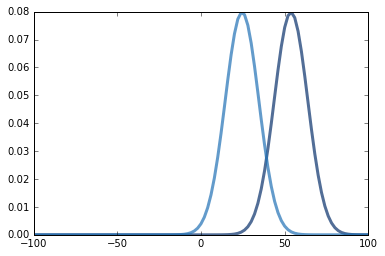

In [123]:
# plot the marginals and print the posterior means
x_pdf = joint.Marginal(0)
y_pdf = joint.Marginal(1)
print(x_pdf.Mean())
print(y_pdf.Mean())
thinkplot.Pdf(x_pdf)
thinkplot.Pdf(y_pdf)

In [124]:
print(x_pdf.Std())
print(y_pdf.Std())

9.99986911264
10.0


Based on the mean and standard deviation results, we are fairly certain that we are within 10 meters of the estimated means, which appears to be somewhere in the blue area of the last contour graph.

## #5. Raining in Seattle
#### This btp was introduced to me by Allen Downey and uses information to construct the prior from the following site: http://www.wrcc.dri.edu/htmlfiles/hrsofppt.html

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle? 

Hypotheses:
A. It is raining
B. It is not raining

Priors: 
A. There is a 9.4 percent chance that it is raining during an hour of the year in Seattle, regardless of what your friends say.
B. There is a 90.6 percent chance that it is not raining during an hour of the year in Seattle.

Likelihoods:
A. (2/3)*(2/3)*(2/3) = 8/27
B. (1/3)*(1/3)*(1/3) = 1/27

Unnormalized Posteriors:
A. 0.094*likelihood = 0.027852
B. 0.906*likelihood = 0.033555
sum = 0.0614

Final Posteriors:
A. 0.4536
B. 0.5465

So, there is a 45.4% chance that is it actually raining in Seattle!

## #6. 1984

#### This problem is by Katerina Zoltan.

The place: Airstrip One. The reason: thoughtcrime. The time: ???

John's parents were taken by the Thought Police and erased from all records. John is being initiated into the Youth League and must pass a test. He is asked whether his parents are good comrades. It is not clear what John's admission officer knows:

1. He may know that John's parents have been erased and that John did not give them away.
2. He may know only that John's parents have been erased.
3. He may not know that John's parents have been erased.

It is a well known fact that children who have parents that are 'good comrades' have twice the chances of passing the test. However, if the admission officer knows that their parents committed thoughtcrime (but not that they have been erased yet), a child that gave his parents away has three times the chances of getting in than a child who did not give them away.

And if the admission officer knows the specifics of the arrest, a child that denies that the records are false and their parents existed has a 1/3 chance of getting in, while one who pretends that his parents never existed has a 2/3 chance. Lying to an admission officer that knows the parents have been erased will ensure that the child does not get in. Telling an admission officer that your parents do not exist when he does not know this will give you a 1/3 chance of getting in.

There is a 60% chance the admission officer knows nothing, a 25% chance that he knows the parents have been erased, and a 15% chance that the officer knows all of the details. John says that he never had parents and is admitted into the Youth League. What did his admission officer know?

In [111]:
police_knows = {'nothing':0.6, 'partial':0.25, 'all':0.15}

class Police(Suite):

    def Likelihood(self, data, hypo):
        if data == 'commited thoughtcrime':
            if hypo == 'all':
                return 0
            elif hypo == 'partial':
                return 1
            elif hypo == 'nothing':
                return 3
        elif data == 'nothing':
            if hypo == 'all':
                return 2
            elif hypo == 'partial':
                return 1
            elif hypo == 'nothing':
                return 1
        elif data == 'good comrades':
            if hypo == 'all':
                return 0
            elif hypo == 'partial':
                return 0
            elif hypo == 'nothing':
                return 2
        
print(Police(police_knows))

Police({'nothing': 0.6, 'all': 0.15, 'partial': 0.25})


In [112]:
pmf = Police(police_knows)
pmf.Update('nothing')
pmf.Print()

all 0.260869565217
nothing 0.521739130435
partial 0.217391304348


These results show that regardless of how much the police knew about John's parents, he still always had a chance of getting admitted into the Youth League. However, it is most likely, based on what John told the police and the fact that he got admitted, that the police did not know anything about his parents.

### I included the allergic diners and gluten sensitivity problem from Chapter 5 in my second report.

## Project Update:


I have not yet decided what project I want to do, but I have a few ideas. Some of them involve Bayesian linear regression and are inspired by a problem I wrote (but have not yet solved) about pasta sauce recipes, but I am also interested in possibly investigating the orange tabby cat problem further.